<a href="https://colab.research.google.com/github/nancymatijas/OSiRV-Projekt/blob/main/zadnja.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install segmentation_models_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 15.1 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=e0568d039f300ffd6e094df9428e425e248959fc891c4ab74d98cf2f1975b9b9
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=1ec338acade76381e3f6075b6355dec588baca05f564b0cb701afcb2caae0135
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels


In [2]:
!pip install med2image

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.5/41.5 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.3/224.3 kB 13.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.4/298.4 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 22.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for med2image: filename=med2image-2.6.6-py3-none-any.whl size=18863 sha256=2760317b062a68fe2acc3f88f82b9c8bac1390fd1aac6b2a995993f204e5ab20
  Stored in directory: /root/.cache/pip/wheels/07/cc/8e/2f95f14d9c19410733709350972e7e8dc4db6b13ba29c976ad
  Created wheel for pfmisc: filename=pfmisc-2.2.14-py3-none-any.whl size=45

In [3]:
!pip install -U segmentation-models-pytorch

In [4]:
import segmentation_models_pytorch as smp
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from google.colab import drive
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import albumentations as A
import torch.nn.functional as F
import pandas as pd
import nibabel as nib
from tqdm import tqdm

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
data = pd.read_csv('/content/drive/MyDrive/MICCAI_BraTS2020_TrainingData2/name_mapping.csv')
data.head(5)

,Grade,BraTS_2017_subject_ID,BraTS_2018_subject_ID,TCGA_TCIA_subject_ID,BraTS_2019_subject_ID,BraTS_2020_subject_ID
0,HGG,Brats17_CBICA_AAB_1,Brats18_CBICA_AAB_1,NaN,BraTS19_CBICA_AAB_1,BraTS20_Training_001
1,HGG,Brats17_CBICA_AAG_1,Brats18_CBICA_AAG_1,NaN,BraTS19_CBICA_AAG_1,BraTS20_Training_002
2,HGG,Brats17_CBICA_AAL_1,Brats18_CBICA_AAL_1,NaN,BraTS19_CBICA_AAL_1,BraTS20_Training_003
3,HGG,Brats17_CBICA_AAP_1,Brats18_CBICA_AAP_1,NaN,BraTS19_CBICA_AAP_1,BraTS20_Training_004
4,HGG,Brats17_CBICA_ABB_1,Brats18_CBICA_ABB_1,NaN,BraTS19_CBICA_ABB_1,BraTS20_Training_005


In [11]:
root = '/content/drive/MyDrive/MICCAI_BraTS2020_TrainingData2'
rootlist = []
totlist = []
for filename_root in tqdm(np.sort(os.listdir(root))[:-2]):
    subpath = os.path.join(root, filename_root)
    filelist = []
    for filename in np.sort(os.listdir(subpath)):
        filelist.append(os.path.join(subpath, filename))
    rootlist.append(filename_root)
    totlist.append(filelist)

maps = pd.concat([pd.DataFrame(rootlist, columns = ['DIR']),
                  pd.DataFrame(totlist, columns = ['flair', 'seg', 't1', 't1ce', 't2'])], axis = 1)

maps.to_csv('links.csv', index = False)

100%|██████████| 5/5 [00:00<00:00, 1365.96it/s]


In [12]:
imgpath = {
              'seg': [],
              't1': [],
              't1ce': [],
              't2': [],
              'flair': []
          }

for path in data['BraTS_2020_subject_ID']:
    patient = os.path.join(root, path)
    for name in imgpath:
      imgpath[name].append(os.path.join(patient, path + f'_{name}.nii'))
imgpath['seg'][:5]

['/content/drive/MyDrive/MICCAI_BraTS2020_TrainingData2/BraTS20_Training_001/BraTS20_Training_001_seg.nii',
 '/content/drive/MyDrive/MICCAI_BraTS2020_TrainingData2/BraTS20_Training_002/BraTS20_Training_002_seg.nii',
 '/content/drive/MyDrive/MICCAI_BraTS2020_TrainingData2/BraTS20_Training_003/BraTS20_Training_003_seg.nii',
 '/content/drive/MyDrive/MICCAI_BraTS2020_TrainingData2/BraTS20_Training_004/BraTS20_Training_004_seg.nii',
 '/content/drive/MyDrive/MICCAI_BraTS2020_TrainingData2/BraTS20_Training_005/BraTS20_Training_005_seg.nii']

In [13]:
def loadimg(imgpath):
    return nib.load(imgpath).get_fdata()

def ccentre(imgslice, cropx, cropy):
    y, x = imgslice.shape
    startx = x // 2 - (cropx // 2)
    starty = y // 2 - (cropy // 2)
    return imgslice[starty:starty + cropy, startx:startx + cropx]

#def normalizer(imgslice):
#    return (imgslice - imgslice.mean()) / imgslice.std()
def normalizer(imgslice):
    return ((imgslice - imgslice.mean()) / imgslice.std()).astype(np.float32)


In [14]:
! mkdir dataset
! mkdir dataset/t1
! mkdir dataset/t1ce
! mkdir dataset/t2
! mkdir dataset/flair
! mkdir dataset/seg

In [15]:
import os
import gzip

def decompress_nii_gz(input_path, output_path):
    # Check if the file exists
    if not os.path.exists(input_path):
        print(f"Error: File not found - {input_path}")
        return

    # Open the .nii.gz file and decompress the content
    with gzip.open(input_path, 'rb') as f_in:
        nii_content = f_in.read()

    # Save the decompressed content as a .nii file
    with open(output_path, 'wb') as f_out:
        f_out.write(nii_content)

def decompress_all_nii_gz_files(input_directory, output_directory):
    for root, dirs, files in os.walk(input_directory):
        for file in files:
            if file.endswith('.nii.gz'):
                input_path = os.path.join(root, file)

                # Specify the output directory for the decompressed file
                relative_path = os.path.relpath(input_path, input_directory)
                output_path = os.path.join(output_directory, os.path.splitext(relative_path)[0])

                # Ensure the output directory exists
                os.makedirs(os.path.dirname(output_path), exist_ok=True)

                decompress_nii_gz(input_path, output_path)

# Example usage
input_data_directory = '/content/drive/MyDrive/MICCAI_BraTS2020_TrainingData'
output_data_directory = '/content/drive/MyDrive/MICCAI_BraTS2020_TrainingData2'
decompress_all_nii_gz_files(input_data_directory, output_data_directory)


In [16]:
numOfImgsSaved = 0
imgs = {}
imgslice = {}
TOSAVE = 300 # Taking only 5000 instances as i am retraining this nb on CPU

for i in (range(len(imgpath['seg']))):
    for name in imgpath:
        imgs[name] = loadimg(imgpath[name][i])

    for j in range(155): # as there 155 instances for each .nii file
        for name in imgs:
            imgslice[name] = imgs[name][:, :, j]
            imgslice[name] = ccentre(imgslice[name], 128, 128)
        if imgslice['seg'].max() > 0:
            for name in ['t1','t2','t1ce','flair']:
              imgslice[name] = normalizer(imgslice[name])
            for name in imgslice:
              np.save(f'./dataset/{name}/img_{numOfImgsSaved}.npy', imgslice[name])
            numOfImgsSaved += 1

        if numOfImgsSaved == TOSAVE:
          break
    if numOfImgsSaved == TOSAVE:
        break

Text(0.5, 1.0, 't2 mask')

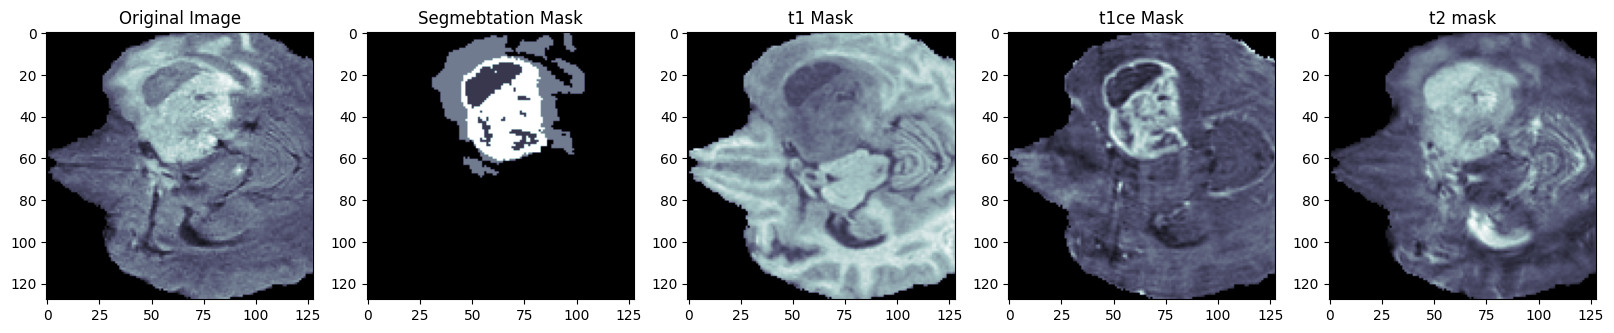

In [17]:
fig = plt.figure(figsize = (20, 10))
plt.subplot(1, 5, 1)
plt.imshow(np.load('dataset/flair/img_25.npy'), cmap = 'bone')
plt.title('Original Image')

plt.subplot(1, 5, 2)
plt.imshow(np.load('dataset/seg/img_25.npy'), cmap = 'bone')
plt.title('Segmebtation Mask')

plt.subplot(1, 5, 3)
plt.imshow(np.load('dataset/t1/img_25.npy'), cmap = 'bone')
plt.title('t1 Mask')

plt.subplot(1, 5, 4)
plt.imshow(np.load('dataset/t1ce/img_25.npy'), cmap = 'bone')
plt.title('t1ce Mask')

plt.subplot(1, 5, 5)
plt.imshow(np.load('dataset/t2/img_25.npy'), cmap = 'bone')
plt.title('t2 mask')

Text(0.5, 1.0, 't2')

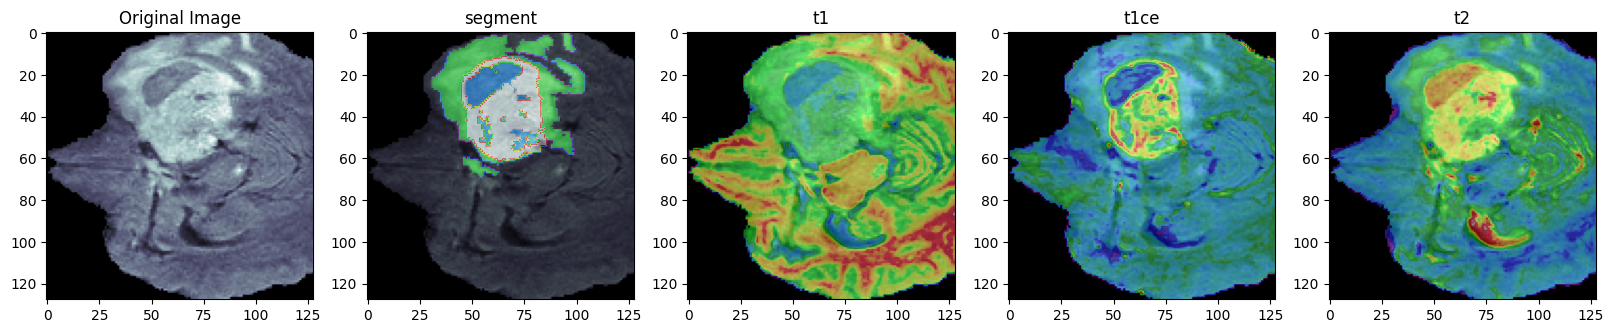

In [18]:
fig = plt.figure(figsize = (20, 10))
plt.subplot(1, 5, 1)
plt.imshow(np.load('dataset/flair/img_25.npy'), cmap = 'bone')
plt.title('Original Image')

plt.subplot(1, 5, 2)
plt.imshow(np.load('dataset/flair/img_25.npy'), cmap = 'bone')
plt.imshow(np.load('dataset/seg/img_25.npy'), alpha = 0.5, cmap = 'nipy_spectral')
plt.title('segment')

plt.subplot(1, 5, 3)
plt.imshow(np.load('dataset/flair/img_25.npy'), cmap = 'bone')
plt.imshow(np.load('dataset/t1/img_25.npy'), alpha = 0.5, cmap = 'nipy_spectral')
plt.title('t1')

plt.subplot(1, 5, 4)
plt.imshow(np.load('dataset/flair/img_25.npy'), cmap = 'bone')
plt.imshow(np.load('dataset/t1ce/img_25.npy'), alpha = 0.5, cmap = 'nipy_spectral')
plt.title('t1ce')

plt.subplot(1, 5, 5)
plt.imshow(np.load('dataset/flair/img_25.npy'), cmap = 'bone')
plt.imshow(np.load('dataset/t2/img_25.npy'), alpha = 0.5, cmap = 'nipy_spectral')
plt.title('t2')

In [20]:
class Dataset(Dataset):
    def __init__(self, datapath = './dataset/', augmentation = None):
        self.augmentation = augmentation
        self.folderpaths = {
                              'mask': os.path.join(datapath, 'seg/'),
                              't1': os.path.join(datapath, 't1/'),
                              't1ce': os.path.join(datapath, 't1ce/'),
                              't2': os.path.join(datapath, 't2/'),
                              'flair': os.path.join(datapath, 'flair/')
                          }

    def __getitem__(self, idx):
        images = {}

        for name in self.folderpaths:
            images[name] = np.load(os.path.join(self.folderpaths[name], f'img_{idx}.npy'))

        if self.augmentation:
            images = self.augmentation(
                                        image = images['flair'],
                                        mask = images['mask'],
                                        t1 = images['t1'],
                                        t1ce = images['t1ce'],
                                        t2 = images['t2'] )
            images['flair'] = images['image']

        for name in images:
            images[name] = torch.from_numpy(images[name])

        # stacking multi ins
        input = torch.stack(
                                [images['t1'],
                                images['t1ce'],
                                images['t2'],
                                images['flair']], dim = 0
                            )

        images['mask'][images['mask'] == 4] = 3
        # one-hot encoding truth label
        images['mask'] = F.one_hot(images['mask'].long().unsqueeze(0), num_classes = 4).permute(0, 3, 1, 2).contiguous().squeeze(0)
        return input.float(), images['mask'].long()

    def __len__(self):
        return len(os.listdir(self.folderpaths['mask'])) - 1

In [21]:
# Tune-able
augmentation = A.Compose([
    A.OneOf([
                A.ElasticTransform(alpha = 120, sigma = 120 * 0.05, alpha_affine = 120 * 0.03, p = 0.5),
                A.GridDistortion(p = 0.5),
                A.OpticalDistortion(distort_limit = 2, shift_limit = 0.5, p = 0.5)
            ], p = 0.8),
    A.RandomBrightnessContrast(p = 0.8)],
    additional_targets = {'t1':'image', 't1ce':'image', 't2':'image'}
                         )

valid_test_dataset = Dataset(datapath = './dataset/', augmentation = None)
train_dataset = Dataset(datapath = './dataset/', augmentation = augmentation)

# 60%/20%/20%
train_length=int(0.6 * len(valid_test_dataset))
valid_length = int(0.2 * len(valid_test_dataset))
test_length = len(valid_test_dataset) - train_length - valid_length

_ , valid_dataset, test_dataset = torch.utils.data.random_split(valid_test_dataset, (train_length,valid_length,test_length), generator=torch.Generator().manual_seed(42))
train_dataset, _ , _ = torch.utils.data.random_split(train_dataset, (train_length,valid_length,test_length), generator=torch.Generator().manual_seed(42))


In [22]:
train_loader = DataLoader(train_dataset,
                      batch_size=16,
                      num_workers=2,
                      shuffle=True)

valid_loader = DataLoader(valid_dataset,
                      batch_size=1,
                      num_workers=2,
                      shuffle=False)

test_loader = DataLoader(test_dataset,
                      batch_size=1,
                      num_workers=2,
                      shuffle=False)

In [23]:
a, b = next(iter(train_loader))

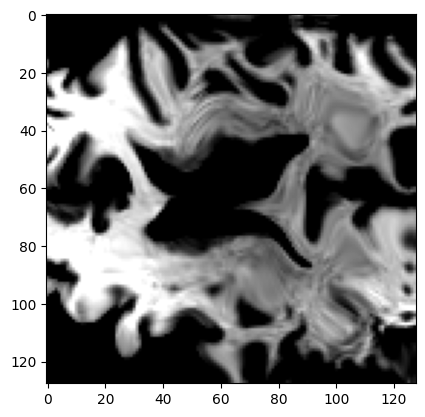

In [24]:
plt.imshow(a[0, 0],cmap='gray')

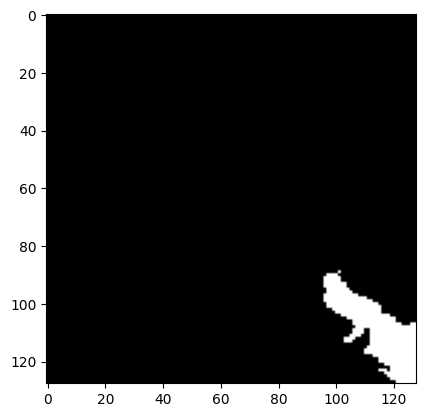

In [25]:
bb = torch.argmax(b, 0)
plt.imshow(bb[0], cmap='gray')

In [60]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [61]:
#Define a dice loss function
def dc_loss(pred, target):
    smooth = 100

    predf = pred.view(-1)
    targetf = target.view(-1)
    intersection = (predf * targetf).sum()

    return 1 - ((2. * intersection + smooth) /
              (predf.sum() + targetf.sum() + smooth))

In [62]:
#Define the UNet architecture


def conv_layer(input_channels, output_channels):     #This is a helper function to create the convolutional blocks
    conv = nn.Sequential(
        nn.Conv2d(input_channels, output_channels, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(output_channels, output_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(output_channels),
        nn.ReLU(inplace=True)
    )
    return conv

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down_1 = conv_layer(3, 64)
        self.down_2 = conv_layer(64, 128)
        self.down_3 = conv_layer(128, 256)
        self.down_4 = conv_layer(256, 512)
        self.down_5 = conv_layer(512, 1024)

        self.up_1 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=2, stride=2)
        self.up_conv_1 = conv_layer(1024, 512)
        self.up_2 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=2, stride=2)
        self.up_conv_2 = conv_layer(512, 256)
        self.up_3 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2)
        self.up_conv_3 = conv_layer(256, 128)
        self.up_4 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2)
        self.up_conv_4 = conv_layer(128, 64)

        self.output = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1, padding=0)
        self.output_activation = nn.Sigmoid()

    def forward(self, img):     #The print statements can be used to visualize the input and output sizes for debugging
        x1 = self.down_1(img)
        #print(x1.size())
        x2 = self.max_pool(x1)
        #print(x2.size())
        x3 = self.down_2(x2)
        #print(x3.size())
        x4 = self.max_pool(x3)
        #print(x4.size())
        x5 = self.down_3(x4)
        #print(x5.size())
        x6 = self.max_pool(x5)
        #print(x6.size())
        x7 = self.down_4(x6)
        #print(x7.size())
        x8 = self.max_pool(x7)
        #print(x8.size())
        x9 = self.down_5(x8)
        #print(x9.size())

        x = self.up_1(x9)
        #print(x.size())
        x = self.up_conv_1(torch.cat([x, x7], 1))
        #print(x.size())
        x = self.up_2(x)
        #print(x.size())
        x = self.up_conv_2(torch.cat([x, x5], 1))
        #print(x.size())
        x = self.up_3(x)
        #print(x.size())
        x = self.up_conv_3(torch.cat([x, x3], 1))
        #print(x.size())
        x = self.up_4(x)
        #print(x.size())
        x = self.up_conv_4(torch.cat([x, x1], 1))
        #print(x.size())

        x = self.output(x)
        x = self.output_activation(x)
        #print(x.size())

        return x


In [65]:
#Initialize the model and optimizer
model = UNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001, betas=(0.9,0.999))